In [1]:
import cv2
from PIL import Image
import numpy as np
from IPython.display import display, Image as IPythonImage

In [2]:
from matplotlib import pyplot as plt

In [3]:
image_path = "./cyto_the_kid.jpg"

In [4]:
def showimg(img):
    # cv2 images are in bgr by default and IPython assumes RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))

In [5]:
img0 = cv2.imread(image_path)
img0g = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

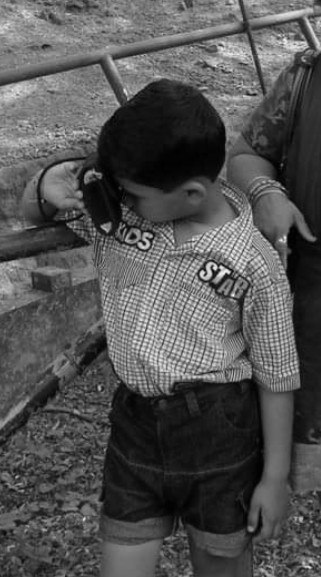

In [7]:
display(Image.fromarray(img0g))

In [20]:
img0g

array([[134, 142, 134, ...,  44,  34,  31],
       [139, 134, 128, ...,  46,  43,  38],
       [147, 142, 143, ...,  56,  53,  45],
       ...,
       [ 57,  73,  69, ...,  90,  73,  64],
       [ 42,  65,  58, ..., 102,  88,  78],
       [ 34,  50,  50, ..., 124, 127, 117]], dtype=uint8)

# Bit Plane Slicing

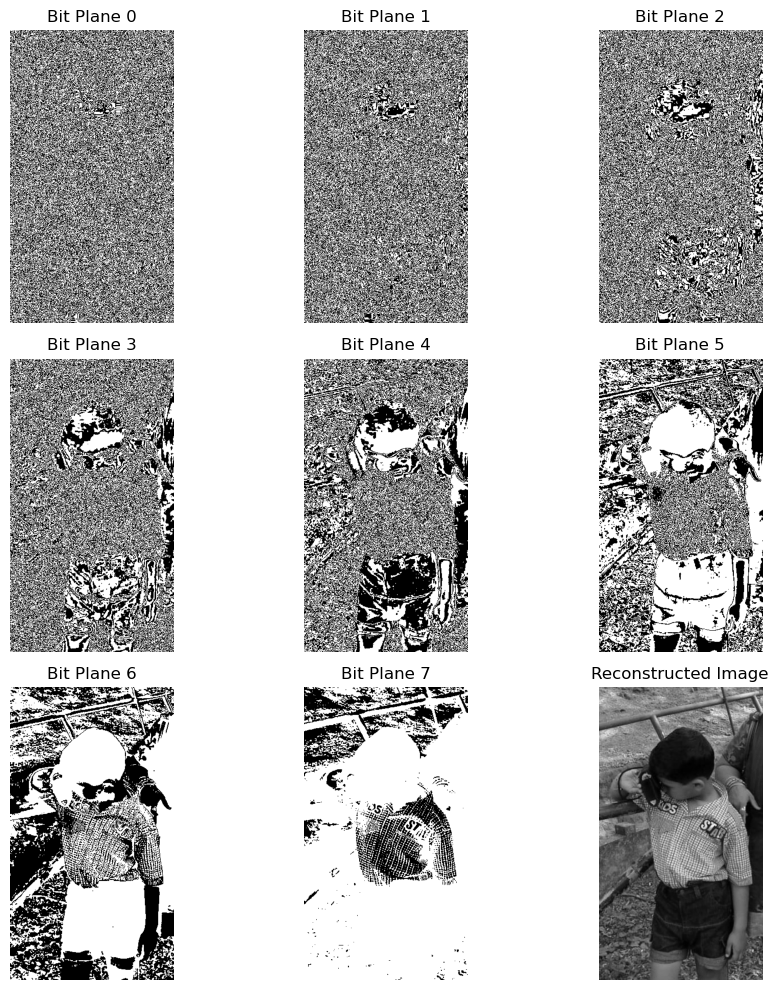

In [14]:
#bit_planes = extract_bit_planes(img0g)

plt.figure(figsize=(10, 10))

# initialize black image, later superpose bit planes to it
reconstructed = np.zeros(img0g.shape, dtype=np.uint8)
for i in range(8):

    # extract bit plane
    halved_image_i_times = (img0g >> i)
    flipped_lsb = halved_image_i_times ^ 1
    only_the_flipped_lsb = flipped_lsb & 1
    # Scale to 255 for visualization
    bit_plane = only_the_flipped_lsb * 255
    bit_plane = bit_plane.astype(np.uint8)

    # plot the bit plane
    plt.subplot(3, 3, i + 1)
    plt.imshow(bit_plane, cmap='gray')
    plt.title(f'Bit Plane {i}')
    plt.axis('off')

    # superposition of bitmaps, enhanced graylevel-wise
    # i.e. 0th graylevel scaled to 0s and 1s 7th graylevel scaled to 0s and 128s
    reconstructed += bit_plane * 2 ** i

# plotting the final superposed enhanced bitmaps
plt.subplot(3, 3, 9)
plt.imshow(reconstructed, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Averaging filter
## 3x3 Kernel

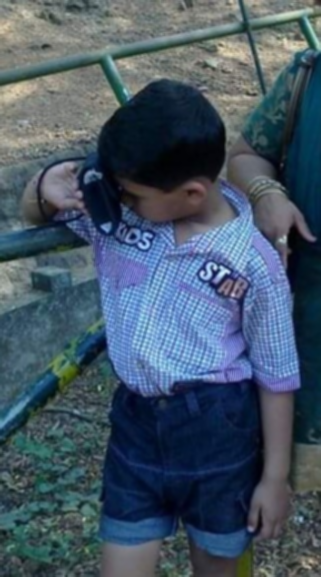

In [15]:
kernel = np.ones((3,3), np.float32)/9
# SAME AS cv2.blur(img0, (3, 3))
img_3_3_filtered = cv2.filter2D(img0, -1, kernel)
showimg(img_3_3_filtered)

## 5x5 Kernel

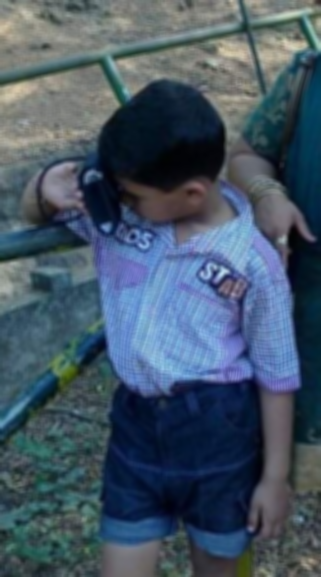

In [16]:
kernel = np.ones((5,5), np.float32)/25
# SAME AS cv2.blur(img0, (5, 5))
img_5_5_filtered = cv2.filter2D(img0, -1, kernel)
showimg(img_5_5_filtered)

## 10x15 Kernel

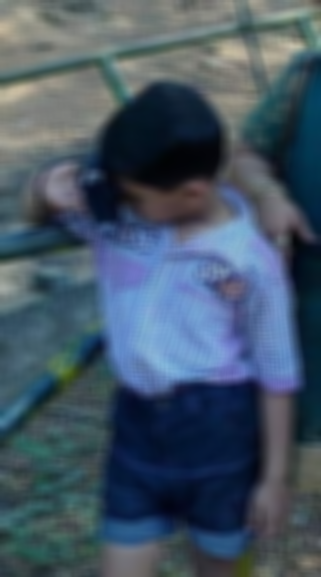

In [17]:
kernel = np.ones((10,15), np.float32)/150
# SAME AS cv2.blur(img0, (10, 15))
img_10_15_filtered = cv2.filter2D(img0, -1, kernel)
showimg(img_10_15_filtered)

# Gaussian Blur (5x5)

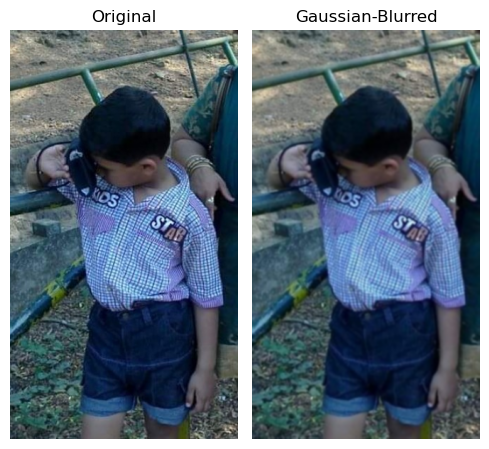

In [18]:
gblur = cv2.GaussianBlur(img0, (5, 5), 0)

plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gblur, cv2.COLOR_BGR2RGB))
plt.title("Gaussian-Blurred")
plt.axis('off')
plt.tight_layout()
plt.show()

# Contrast Stretching

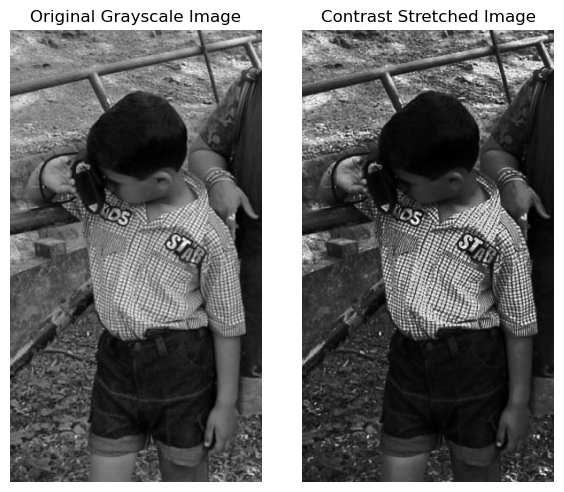

In [27]:
# inflection point 1
r1 = 100
s1 = 60

# inflection point 2
r2 = 200
s2 = 240

alpha = s1 / r1  # at the first slope, T(r < r1) = alpha * r
beta = (s2 - s1) / (r2 - r1)  # at the second slope, T(r1 < r < r2) = beta * r + (alpha - beta) * r1
gamma = (255 - s2) / (255 - r2)  # at the third slope, T(r > r2) = gamma * r + (alpha - beta) * r1 + (beta - alpha) * r2

contrast_transform = {0: lambda r: alpha * r, 1: lambda r: beta * r + (alpha - beta) * r1 , 2: lambda r: gamma * r + (alpha - beta) * r1 + (beta - alpha) * r2}

contrast_stretched_image = np.zeros(img0g.shape, dtype = np.uint8)

for i in range(img0g.shape[0]):
    for j in range(img0g.shape[1]):
        if img0g[i][j] > r2:
            contrast_stretched_image[i][j] = contrast_transform[2](img0g[i][j])
        elif img0g[i][j] > r1:
            contrast_stretched_image[i][j] = contrast_transform[1](img0g[i][j])
        else:
            contrast_stretched_image[i][j] = contrast_transform[0](img0g[i][j])


plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 1)
plt.imshow(img0g, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(contrast_stretched_image, cmap='gray')
plt.title('Contrast Stretched Image')
plt.axis('off')

plt.tight_layout()
plt.show()